#### 一个简单的解方程的例子

给一个简单的方程：

$ \frac{\partial u}{\partial x} = 2\frac{\partial u}{\partial t} + u $

边界调节条件：$ u(x, 0) = 6e^{-3x} $

自变量：x，t（输入）

因变量：u（输出）

求出范围为 [0,2] 的所有 $x$ 和范围为 [0,1] 的所有 $t$ 的 $u(x,t)$ 当我们解析求解这个问题时，我们找到了解：$u(x,t) = 6e^{(-3x-2t)}$


In [19]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [20]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 构建PINN模型

In [21]:
class PINN(nn.Module):
    def __init__(self, N_iput_dim=2, N_hidden_dim=5, N_hidden_layers=4):
        super().__init__()
        self.input = nn.Linear(N_iput_dim, N_hidden_dim).to(device)
        self.hidden = nn.ModuleList([nn.Linear(N_hidden_dim, N_hidden_dim).to(device) for _ in range(N_hidden_layers)])
        self.output = nn.Linear(N_hidden_dim, 1).to(device)
        self.activation = nn.Tanh()

    def forward(self, x, t):
        x = torch.cat([x, t], dim=1)
        x = self.activation(self.input(x))
        for layer in self.hidden:
            x = self.activation(layer(x))
        x = self.output(x)

        return x

### 定义条件约束

In [22]:
def f(x, t, net):
    u = net(x, t) # 因变量u由基于自变量x，t的网络给出
    ## Based on f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    pde = u_x - 2*u_t - u
    
    return pde

## 边界条件的数据
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500, 1))
t_bc = np.zeros((500, 1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [23]:
net = PINN()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#### 开始训练

In [24]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = torch.from_numpy(x_bc).float().to(device)
    pt_t_bc = torch.from_numpy(t_bc).float().to(device)
    pt_u_bc = torch.from_numpy(u_bc).float().to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = torch.from_numpy(x_collocation).float().requires_grad_(True).to(device)
    pt_t_collocation = torch.from_numpy(t_collocation).float().requires_grad_(True).to(device)
    pt_all_zeros = torch.from_numpy(all_zeros).float().requires_grad_(True).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch%1000 == 0:
    	print(epoch,"Traning Loss:",loss.item())

0 Traning Loss: 2.037463426589966
1000 Traning Loss: 0.02358754724264145
2000 Traning Loss: 0.0021332078613340855
3000 Traning Loss: 0.0010395102435722947
4000 Traning Loss: 0.00040876344428397715
5000 Traning Loss: 0.0002578617131803185
6000 Traning Loss: 0.00016792109818197787
7000 Traning Loss: 0.00015784076822455972
8000 Traning Loss: 0.00011810683645308018
9000 Traning Loss: 0.00010076464241137728
10000 Traning Loss: 9.797187522053719e-05
11000 Traning Loss: 9.339809184893966e-05
12000 Traning Loss: 0.0001245369203388691
13000 Traning Loss: 5.28547061549034e-05
14000 Traning Loss: 7.078761700540781e-05
15000 Traning Loss: 3.650680810096674e-05
16000 Traning Loss: 3.136807572445832e-05
17000 Traning Loss: 2.1637695681420155e-05
18000 Traning Loss: 2.0944975403835997e-05
19000 Traning Loss: 2.38297761825379e-05


In [39]:
x = np.arange(0, 2 , 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = torch.from_numpy(x).float().to(device)
pt_t = torch.from_numpy(t).float().to(device)
pt_u = net(pt_x, pt_t)
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

In [40]:
def f_u(x, t):
    return 6*np.exp(-3*x - 2*t)

In [41]:
u_real = f_u(x, t).reshape(ms_x.shape)

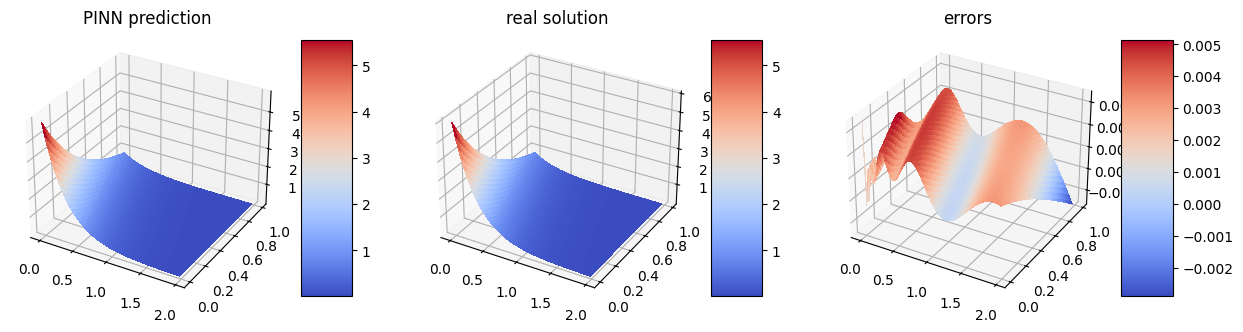

In [51]:
fig = plt.figure(figsize=(15, 14))
# 第一个子图
ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.3, aspect=5)
ax.set_title('PINN prediction')

# 第二个子图
ax = fig.add_subplot(132, projection='3d')
surf = ax.plot_surface(ms_x, ms_t, u_real, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.3, aspect=5)
ax.set_title('real solution')

# 第三个子图
ax = fig.add_subplot(133, projection='3d')
surf = ax.plot_surface(ms_x, ms_t, u_real-ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.3, aspect=5)

ax.set_title('errors')

plt.show()